<a href="https://colab.research.google.com/github/sambit-star/Automatic_Ticket_Classification/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [54]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [55]:
# Opening JSON file
f = "/content/complaints-2021-05-14_08_16.json" # Write the path to your data file and load it

# returns JSON object as
# a dictionary
with open(f, 'r') as file:
  data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [56]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [57]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [58]:
#Assign new column names
df = df.rename(columns=lambda x: re.sub(r"_source.", "", x))
df.columns

Index(['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [59]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"].replace("", np.nan, inplace=True)
df["complaint_what_happened"]

<ipython-input-59-a0fe2d0c2fc6>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,complaint_what_happened
0,NaN
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN
4,NaN
...,...
78308,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


In [60]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_what_happened"], inplace=True)
df['complaint_what_happened']

,complaint_what_happened
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...
11,"On XX/XX/2018, while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...
...,...
78303,After being a Chase Card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [61]:
# Write your function here to clean the text and remove all the unnecessary elements.
df['complaint_what_happened'] = df['complaint_what_happened'].str.lower()
df['complaint_what_happened']

# Remove text in square brackets
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: re.sub('\[.*?\]', '', x))
df['complaint_what_happened']

# Remove punctuation
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['complaint_what_happened']

# Remove words containing numbers
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: re.sub('\w*\d\w*', '', x))
df['complaint_what_happened']

,complaint_what_happened
1,good morning my name is xxxx xxxx and i apprec...
2,i upgraded my xxxx xxxx card in and was told ...
10,chase card was reported on however fraudulent...
11,on while trying to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...
...,...
78303,after being a chase card customer for well ove...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,i am not familiar with xxxx pay and did not un...
78311,i have had flawless credit for yrs ive had ch...


In [62]:
#Write your function to Lemmatize the texts
df['complaint_what_happened_lemma'] = df['complaint_what_happened'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x))]))
df['complaint_what_happened_lemma']

,complaint_what_happened_lemma
1,good morning my name be xxxx xxxx and I apprec...
2,I upgrade my xxxx xxxx card in and be tell b...
10,chase card be report on however fraudulent a...
11,on while try to book a xxxx xxxx ticket ...
14,my grand son give I check for I deposit it i...
...,...
78303,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I be not familiar with xxxx pay and do not und...
78311,I have have flawless credit for yrs I ve hav...


In [63]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_what_happened', 'complaint_what_happened_lemma']]

In [64]:
df_clean

,complaint_what_happened,complaint_what_happened_lemma
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [65]:
#Write your function to extract the POS tags

def pos_tag(text):
  # write your code here
  doc = nlp(text)
  return [(token.text, token.tag_) for token in doc]




#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["complaint_what_happened_lemma"].apply(lambda x: ' '.join([word for word, tag in pos_tag(x) if tag == "NN"]))


<ipython-input-65-8d8c6c7f7cb8>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
pos_tag("good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help")

[('good', 'JJ'),
 ('morning', 'NN'),
 ('my', 'PRP$'),
 ('name', 'NN'),
 ('is', 'VBZ'),
 ('xxxx', 'NNP'),
 ('xxxx', 'NNP'),
 ('and', 'CC'),
 ('i', 'PRP'),
 ('appreciate', 'VBP'),
 ('it', 'PRP'),
 ('if', 'IN'),
 ('you', 'PRP'),
 ('could', 'MD'),
 ('help', 'VB'),
 ('me', 'PRP'),
 ('put', 'VB'),
 ('a', 'DT'),
 ('stop', 'NN'),
 ('to', 'TO'),
 ('chase', 'VB'),
 ('bank', 'NN'),
 ('cardmember', 'NN'),
 ('services', 'NNS'),
 ('in', 'IN'),
 ('i', 'PRP'),
 ('wrote', 'VBD'),
 ('to', 'TO'),
 ('chase', 'VB'),
 ('asking', 'VBG'),
 ('for', 'IN'),
 ('debt', 'NN'),
 ('verification', 'NN'),
 ('and', 'CC'),
 ('what', 'WP'),
 ('they', 'PRP'),
 ('sent', 'VBD'),
 ('me', 'PRP'),
 ('a', 'DT'),
 ('statement', 'NN'),
 ('which', 'WDT'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('acceptable', 'JJ'),
 ('i', 'PRP'),
 ('am', 'VBP'),
 ('asking', 'VBG'),
 ('the', 'DT'),
 ('bank', 'NN'),
 ('to', 'TO'),
 ('validate', 'VB'),
 ('the', 'DT'),
 ('debt', 'NN'),
 ('instead', 'RB'),
 ('i', 'PRP'),
 ('been', 'VBD'),
 ('receiving', 'VBG'

In [67]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [68]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['Complaint_length'] = df_clean['complaint_POS_removed'].str.len()
df_clean

<ipython-input-68-af77588180d6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,220
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,669
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,725
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,553


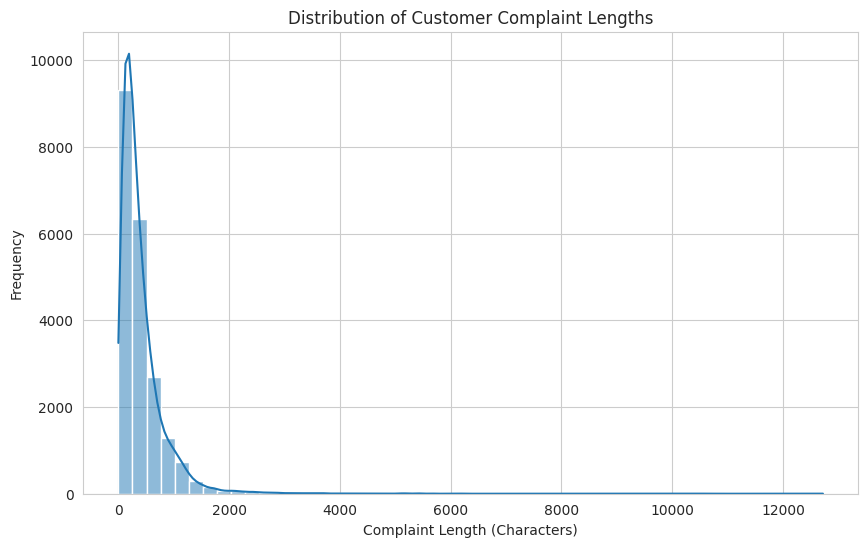

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the visualization
sns.set_style('whitegrid')

# Create a histogram of the complaint lengths
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(df_clean['Complaint_length'], bins=50, kde=True)

# Set plot labels and title
plt.xlabel('Complaint Length (Characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Customer Complaint Lengths')

# Show the plot
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [70]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud

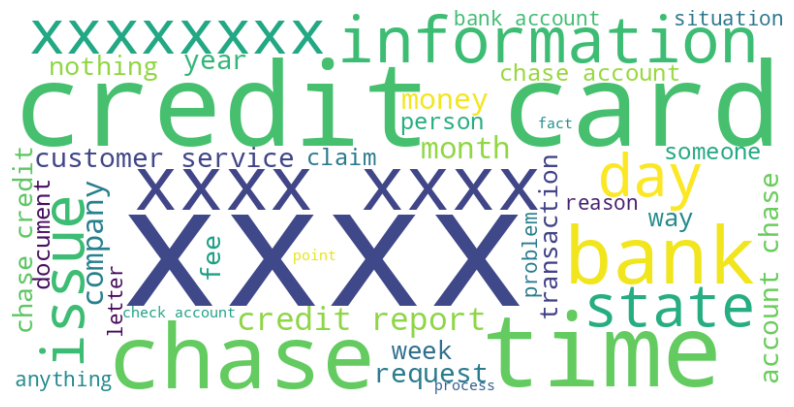

In [71]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all the cleaned complaints into a single string
text = ' '.join(df_clean['complaint_POS_removed'].astype(str).tolist())

# Create a WordCloud object with desired parameters
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      stopwords=STOPWORDS,
                      max_words=40,
                      contour_width=3,
                      contour_color='steelblue')

# Generate the word cloud from the combined text
wordcloud.generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [72]:
frequencies = wordcloud.words_

# Print the top 40 words
for word, frequency in frequencies.items():
    print(f"{word}: {frequency}")

xxxx: 1.0
credit card: 0.9894444872486324
time: 0.7249402881577933
chase: 0.5565143693658987
bank: 0.43046459665613684
xxxx xxxx: 0.3912473996455813
information: 0.3863163571923877
xxxxxxxx: 0.362893905539718
day: 0.33253717543724476
issue: 0.32098004468757224
state: 0.30603282225132905
credit report: 0.3025656830264273
month: 0.2658140072424686
company: 0.25980429925263887
money: 0.24031127205485786
customer service: 0.23561137221665768
year: 0.23183604283843132
request: 0.2287541413051853
account chase: 0.22451652669697203
chase credit: 0.2163494876338701
nothing: 0.20980044687572233
fee: 0.2082594961090993
way: 0.20024655212265968
week: 0.19870560135603668
transaction: 0.1983203636643809
chase account: 0.19539255720779722
claim: 0.1915401802912397
document: 0.18976808690962324
person: 0.18945989675629862
someone: 0.18622390014639031
bank account: 0.18537637722474767
anything: 0.18522228214808537
reason: 0.18329609368980662
letter: 0.18244857076816395
problem: 0.17682410046998998
sit

In [73]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

<ipython-input-73-2ee47e6ecbae>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [74]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter

# Combine all complaints into a single string
all_text = ' '.join(df_clean['Complaint_clean'].astype(str).tolist())

# Split the string into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Get the 30 most common words
top_30_words = word_counts.most_common(30)

# Print the top 30 words and their frequencies
for word, frequency in top_30_words:
    print(f"{word}: {frequency}")

chase: 52745
xxxx: 48183
account: 46732
credit: 33464
card: 30216
bank: 21611
payment: 21158
time: 16008
charge: 14153
xxxxxxxx: 13583
day: 12971
check: 12100
money: 11953
loan: 10899
information: 9643
letter: 9598
fee: 8890
report: 8855
number: 8614
transaction: 8564
month: 8461
amount: 8422
call: 8365
year: 8289
customer: 8137
mortgage: 8072
balance: 7759
service: 7698
phone: 7570
company: 7534


In [75]:
#Print the top 10 words in the unigram frequency
# Get the 10 most common words
top_10_words = word_counts.most_common(10)

# Print the top 30 words and their frequencies
for word, frequency in top_10_words:
    print(f"{word}: {frequency}")

chase: 52745
xxxx: 48183
account: 46732
credit: 33464
card: 30216
bank: 21611
payment: 21158
time: 16008
charge: 14153
xxxxxxxx: 13583


In [76]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter
import nltk
from nltk import bigrams

nltk.download('punkt_tab')  # Download necessary data for tokenization (if not already downloaded)

# Combine all complaints into a single string
all_text = ' '.join(df_clean['Complaint_clean'].astype(str).tolist())

# Tokenize the text into words
tokens = nltk.word_tokenize(all_text)

# Generate bigrams
bigram_list = list(bigrams(tokens))

# Count the frequency of each bigram
bigram_counts = Counter(bigram_list)

# Get the 30 most common bigrams
top_30_bigrams = bigram_counts.most_common(30)

# Print the top 30 bigrams and their frequencies
for bigram, frequency in top_30_bigrams:
    print(f"{bigram}: {frequency}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


('credit', 'card'): 12842
('xxxx', 'xxxx'): 5078
('credit', 'report'): 3927
('customer', 'service'): 3058
('account', 'chase'): 2914
('chase', 'credit'): 2808
('chase', 'account'): 2536
('bank', 'account'): 2406
('check', 'account'): 2251
('account', 'account'): 2103
('chase', 'bank'): 2078
('debit', 'card'): 1965
('checking', 'account'): 1846
('account', 'xxxx'): 1741
('chase', 'card'): 1731
('credit', 'score'): 1707
('xxxx', 'chase'): 1706
('xxxx', 'credit'): 1671
('phone', 'call'): 1649
('number', 'xxxx'): 1641
('card', 'account'): 1624
('card', 'chase'): 1517
('account', 'credit'): 1442
('xxxx', 'account'): 1442
('chase', 'xxxx'): 1332
('interest', 'rate'): 1288
('money', 'account'): 1268
('account', 'bank'): 1258
('business', 'day'): 1254
('phone', 'number'): 1240


In [77]:
#Print the top 10 words in the bigram frequency

# Get the 10 most common bigrams
top_10_bigrams = bigram_counts.most_common(10)

# Print the top 10 bigrams and their frequencies
for bigram, frequency in top_10_bigrams:
    print(f"{bigram}: {frequency}")

('credit', 'card'): 12842
('xxxx', 'xxxx'): 5078
('credit', 'report'): 3927
('customer', 'service'): 3058
('account', 'chase'): 2914
('chase', 'credit'): 2808
('chase', 'account'): 2536
('bank', 'account'): 2406
('check', 'account'): 2251
('account', 'account'): 2103


In [78]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
from collections import Counter
import nltk
from nltk import trigrams
# Generate bigrams
trigram_list = list(trigrams(tokens))

# Count the frequency of each bigram
trigram_counts = Counter(trigram_list)

# Get the 30 most common bigrams
top_30_trigrams = trigram_counts.most_common(30)

# Print the top 30 bigrams and their frequencies
for trigram, frequency in top_30_trigrams:
    print(f"{trigram}: {frequency}")

('chase', 'credit', 'card'): 1899
('credit', 'card', 'account'): 1071
('credit', 'card', 'company'): 982
('xxxx', 'credit', 'card'): 824
('xxxx', 'xxxx', 'xxxx'): 797
('credit', 'card', 'chase'): 701
('inquiry', 'credit', 'report'): 488
('credit', 'card', 'credit'): 484
('account', 'credit', 'card'): 432
('credit', 'card', 'xxxx'): 403
('chase', 'customer', 'service'): 386
('credit', 'reporting', 'agency'): 382
('charge', 'credit', 'card'): 381
('card', 'credit', 'card'): 372
('chase', 'checking', 'account'): 371
('credit', 'report', 'credit'): 356
('customer', 'service', 'representative'): 339
('credit', 'reporting', 'act'): 338
('credit', 'card', 'payment'): 295
('chase', 'bank', 'account'): 283
('credit', 'card', 'charge'): 272
('bank', 'credit', 'card'): 267
('account', 'credit', 'report'): 264
('account', 'number', 'xxxx'): 264
('account', 'chase', 'account'): 258
('chase', 'card', 'service'): 255
('chase', 'auto', 'finance'): 253
('victim', 'identity', 'theft'): 251
('credit', 'c

In [79]:
#Print the top 10 words in the trigram frequency

# Get the 10 most common trigrams
top_10_trigrams = trigram_counts.most_common(10)

# Print the top 10 trigrams and their frequencies
for trigram, frequency in top_10_trigrams:
    print(f"{trigram}: {frequency}")

('chase', 'credit', 'card'): 1899
('credit', 'card', 'account'): 1071
('credit', 'card', 'company'): 982
('xxxx', 'credit', 'card'): 824
('xxxx', 'xxxx', 'xxxx'): 797
('credit', 'card', 'chase'): 701
('inquiry', 'credit', 'report'): 488
('credit', 'card', 'credit'): 484
('account', 'credit', 'card'): 432
('credit', 'card', 'xxxx'): 403


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [80]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

<ipython-input-80-d4beb8194a2f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147,morning name stop bank service ask debt verifi...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,220,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,669,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,725,risk consumer chase bank app chase year banki...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,553,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [82]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [83]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

# print dtm



## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [84]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [85]:
#Load your nmf_model with the n_components i.e 5

#write the value you want to test out
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [86]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6876

In [87]:
#Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'The top 15 words for topic #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])


The top 15 words for topic #0
['transaction', 'customer', 'transfer', 'number', 'business', 'checking', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'bank', 'check', 'account']
The top 15 words for topic #1
['reason', 'application', 'purchase', 'offer', 'interest', 'month', 'point', 'year', 'score', 'limit', 'account', 'balance', 'chase', 'credit', 'card']
The top 15 words for topic #2
['statement', 'amount', 'property', 'balance', 'rate', 'year', 'time', 'interest', 'modification', 'month', 'home', 'chase', 'mortgage', 'loan', 'payment']
The top 15 words for topic #3
['creditor', 'file', 'date', 'letter', 'score', 'theft', 'account', 'identity', 'debt', 'reporting', 'information', 'company', 'credit', 'inquiry', 'report']
The top 15 words for topic #4
['call', 'refund', 'time', 'service', 'amount', 'email', 'purchase', 'fraud', 'fee', 'merchant', 'claim', 'chase', 'transaction', 'dispute', 'charge']


In [88]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)



In [89]:
#Assign the best topic to each of the cmplaints in Topic Column

#write your code to assign topics to each rows.
df_clean['Topic'] = topic_results.argmax(axis=1)

<ipython-input-89-7b6df2f65f32>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [90]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147,morning name stop bank service ask debt verifi...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0


In [91]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147,morning name stop bank service ask debt verifi...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,33,mishandle account chase auto,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,632,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus xxxxxxxx term everythi...,130,account bank code bonus term everything accou...,0
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,620,chase card decline catering order place brothe...,1
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase reward point month reward account bonus ...,504,chase reward point month reward account bonus ...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,208,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company time share company nothing ref...,81,citizen company time share company nothing ref...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [92]:
#Create the dictionary of Topic names and Topics


Topic_names = { 0:  'Bank Account services',
                1:  'Credit card or prepaid card',
                2: 'Theft/Dispute Reporting',
                3: 'Mortgage/Loan',
                4: 'Others'}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-92-c7a8e6085efd>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
df_clean

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147,morning name stop bank service ask debt verifi...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,Mortgage/Loan
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,Mortgage/Loan
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,Bank Account services
15,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,Mortgage/Loan
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,632,notice account debit card branch customer serv...,Bank Account services
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,563,summer month decline income employment month p...,Theft/Dispute Reporting
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,1142,payment retailer chase pay chase website scam...,Others
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,45,credit card datum credit report company issue,Mortgage/Loan


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [94]:
#Create the dictionary again of Topic names and Topics
Topic_names = { 'Bank Account services': 0,
                'Credit card or prepaid card': 1,
                'Theft/Dispute Reporting': 2,
                'Mortgage/Loan': 3,
                'Others': 4}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-94-37e8c8b4e282>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [95]:
df_clean

,complaint_what_happened,complaint_what_happened_lemma,complaint_POS_removed,Complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,147,morning name stop bank service ask debt verifi...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,110,card agent anniversary date agent information...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,80,chase card report application identity consent...,3
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,391,ticket offer ticket reward card information ...,3
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,162,son chase account fund chase bank account mone...,0
15,can you please remove inquiry,can you please remove inquiry,inquiry,7,inquiry,3
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,632,notice account debit card branch customer serv...,0
20,during the summer months i experience a declin...,during the summer month I experience a decline...,summer month decline income employment month p...,563,summer month decline income employment month p...,2
21,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,1142,payment retailer chase pay chase website scam...,4
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,45,credit card datum credit report company issue,3


In [96]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']]

In [100]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,3
11,on while trying to book a xxxx xxxx ticket ...,3
14,my grand son give me check for i deposit it i...,0
15,can you please remove inquiry,3
17,with out notice jp morgan chase restricted my ...,0
20,during the summer months i experience a declin...,2
21,on xxxx i made a payment to an online retail...,4
23,i have a chase credit card which is incorrectl...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [102]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code to get the Vector count
count_vect = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the text data to create the vector counts
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [103]:
# Create the train & test data using the train_test_split on the tf-idf & topics

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42
)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [114]:
# Write your code here to build any 3 models and evaluate them using the required metrics

#1: Logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred)
precision_logreg = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_logreg = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_logreg = f1_score(y_test, y_pred, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy_logreg)
print("Precision:", precision_logreg)
print("Recall:", recall_logreg)
print("F1-Score:", f1_logreg)
print("Confusion Matrix:\n", conf_matrix)



Accuracy: 0.14285714285714285
Precision: 0.8571428571428571
Recall: 0.14285714285714285
F1-Score: 0.19047619047619047
Confusion Matrix:
 [[0 0 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [0 3 0 0 0]]


In [115]:
#2: DecisionTree:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred)
precision_dt = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_dt = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_dt = f1_score(y_test, y_pred, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1-Score:", f1_dt)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.14285714285714285
Precision: 0.7428571428571429
Recall: 0.14285714285714285
F1-Score: 0.047619047619047616
Confusion Matrix:
 [[0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [1 0 2 0 0]]


In [116]:
#3: RandomForest:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall_rf = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1_rf = f1_score(y_test, y_pred, average='weighted', zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1-Score:", f1_rf)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.42857142857142855
Precision: 0.8857142857142858
Recall: 0.42857142857142855
F1-Score: 0.33333333333333337
Confusion Matrix:
 [[1 0 0 0]
 [1 0 0 0]
 [0 0 2 0]
 [3 0 0 0]]


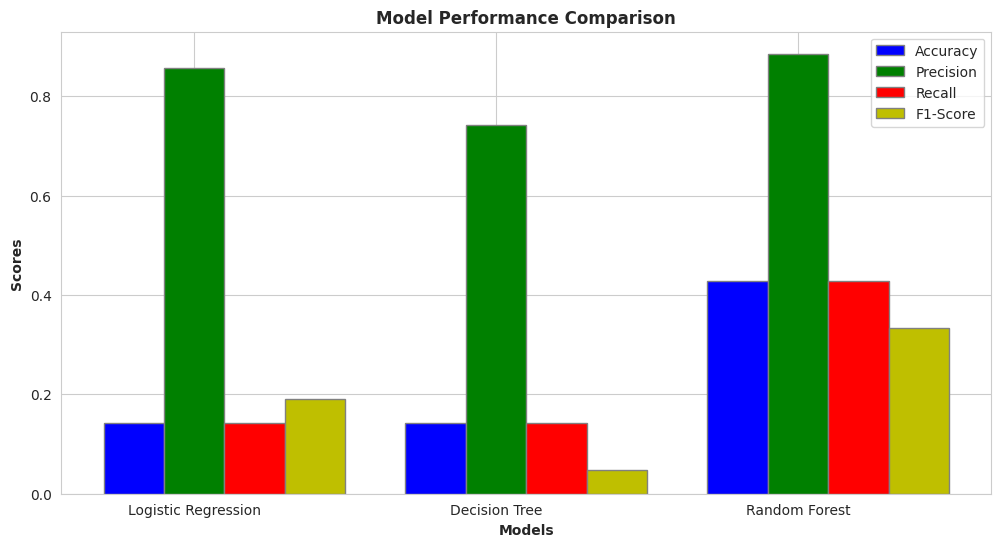

In [118]:
# Visual representation of the model comparison
import matplotlib.pyplot as plt
import numpy as np

# Create a list of models and metrics
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracy = [accuracy_logreg, accuracy_dt, accuracy_rf]
precision = [precision_logreg, precision_dt, precision_rf]
recall = [recall_logreg, recall_dt, recall_rf]
f1 = [f1_logreg, f1_dt, f1_rf]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(accuracy))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1, color='y', width=bar_width, edgecolor='grey', label='F1-Score')

# Add labels, title, and legend
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Model Performance Comparison', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(accuracy))], models)
plt.legend()

# Show the chart
plt.show()

**From the aove comparison it seems that Random Forest gives best results considering the parameters: accuracy, precision, recall, f1**